In [1]:
import psycopg2

In [2]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

### Extracting nouns and a list of adjectives associated with each noun

In [3]:
import itertools
import time
from datetime import timedelta, datetime
from collections import defaultdict

In [22]:
try:
    cursor.execute("SELECT DISTINCT noun, STRING_AGG(adjective, ',') FROM all_pairs_counts WHERE noun IN (SELECT noun FROM all_pairs_counts WHERE count >= 3 GROUP BY noun HAVING COUNT(*) >= 5) AND adjective IN (SELECT adjective FROM all_pairs_counts GROUP BY adjective HAVING COUNT(*) >= 5) GROUP BY noun")
    adjectives_listed = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [23]:
adjectives_listed[0]

('liberaal',
 'vaba,omane,paduparempoolne,võitlev,juhtiv,üleriigiline,kaasaegne,ülemaailmne,universalistlik,juhitud,peamine,sajaprotsendiline,kaitsev,kahjurõõmus,ohtlik,eluvõõras,eirav,ekstreemne,elav,aus,üle-euroopaline,ülalmainitud,väljajäänud,ühtne,vastuoluline,muutev,kritiseeriv,kõrge,mõjukas,moraalitu,tõsiusklik,teostuv,tundmatu,erinev,esindav,astuv,lilla,neetud,normaalne,kuuluv,kuulus,kosmopoliitne,äärmuslik,äärmine,51aastane,revolutsiooniline,rikkuv,revisionistlik,sirgjooneline,veatu,rahvusvaheline,arukas,töötav,tänane,toonane,vasakpoolne,valitsev,parempoolne,prantsuskeelne,printsipiaalne,uus,viimane,tollane,reformimeelne,juhitav,praegune,vasak,tõeline,olnud,opositsiooniline,ainus,omaaegne,otsustusvõimetu,tulnud,seotud,tulihingeline,endine,võimulolev,noor,radikaalne,fundamentaalne,paremtsentristlik,vabameelne,pannud,pooldav,konservatiivne,mõõdukas,lõtv,majanduslik,läänemeelne,traditsiooniline,kalduv,filosoofiline,järgnev,olev,klassikaline,hääbuv,koduvillane,keskealine,sotsiaalde

In [24]:
len(adjectives_listed)

12772

In [26]:
dict_words = {}

for tup in adjectives_listed:
    dict_words[tup[0]] = tup[1].split(',')

In [28]:
noun_pairs = list(itertools.combinations(dict_words.keys(), 2))
len(noun_pairs)

81555606

In [29]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

similarities = defaultdict(dict)

for pair in noun_pairs:
    first_word = pair[0]
    second_word = pair[1]
    similarity = len(set(dict_words[first_word]) & set(dict_words[second_word]))/len(set(dict_words[first_word]) | set(dict_words[second_word]))
    
    similarities[first_word][second_word] = similarity
    similarities[second_word][first_word] = similarity
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

0:59:03.356798
2:07:14.318767
1:08:10.974192


### t-SNE on similarity matrix

In [30]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

In [31]:
df = pd.DataFrame(similarities)
df = df.reindex(sorted(df.columns), axis=1)
df = df.reindex(sorted(df.index), axis=0)
df = df.fillna(1)

In [32]:
df

,A-klass,A-rühm,B-grupp,Bondi-film,C-vitamiin,CD-plaat,CN-kood,EM-finaalturniir,EM-tsükkel,EM-valikmäng,...,šiiit,šokk,šokolaad,šotlane,šveitslane,šveitslanna,žanr,žest,žürii,ω-3-rasvhape
A-klass,1.000000,0.095238,0.022222,0.042857,0.037736,0.074380,0.034884,0.011905,0.048387,0.021978,...,0.027027,0.058252,0.082353,0.039735,0.036697,0.026667,0.020747,0.033003,0.044643,0.026316
A-rühm,0.095238,1.000000,0.061538,0.086957,0.035714,0.028846,0.015385,0.050847,0.050000,0.060606,...,0.045977,0.054054,0.045455,0.022901,0.046512,0.018868,0.027650,0.021127,0.039409,0.018519
B-grupp,0.022222,0.061538,1.000000,0.057971,0.134021,0.040000,0.022989,0.075949,0.101695,0.120482,...,0.045872,0.028302,0.016575,0.046667,0.056075,0.040541,0.042373,0.016234,0.040000,0.054054
Bondi-film,0.042857,0.086957,0.057971,1.000000,0.045977,0.099010,0.060606,0.064516,0.121951,0.057143,...,0.032609,0.047368,0.037736,0.045455,0.010753,0.000000,0.041284,0.020833,0.053922,0.035088
C-vitamiin,0.037736,0.035714,0.134021,0.045977,1.000000,0.049645,0.049020,0.009804,0.024691,0.018349,...,0.047619,0.044248,0.086022,0.035503,0.031496,0.021505,0.043478,0.037618,0.037037,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
šveitslanna,0.026667,0.018868,0.040541,0.000000,0.021505,0.008772,0.000000,0.044776,0.000000,0.012987,...,0.042105,0.015000,0.011976,0.075758,0.126437,1.000000,0.008734,0.000000,0.028169,0.000000
žanr,0.020747,0.027650,0.042373,0.041284,0.043478,0.059701,0.038462,0.021368,0.018605,0.024896,...,0.063492,0.053824,0.046440,0.047138,0.042969,0.008734,1.000000,0.091121,0.071823,0.022026
žest,0.033003,0.021127,0.016234,0.020833,0.037618,0.029326,0.036789,0.009901,0.010601,0.019481,...,0.037152,0.068127,0.051948,0.050000,0.030864,0.000000,0.091121,1.000000,0.055684,0.023973
žürii,0.044643,0.039409,0.040000,0.053922,0.037037,0.058366,0.026667,0.031818,0.045455,0.035242,...,0.057851,0.068249,0.068852,0.052817,0.045082,0.028169,0.071823,0.055684,1.000000,0.028037


In [33]:
## Change similarity matrix to distance matrix
dist_df = df.apply(lambda x: 1 - x)

In [34]:
dist_df

,A-klass,A-rühm,B-grupp,Bondi-film,C-vitamiin,CD-plaat,CN-kood,EM-finaalturniir,EM-tsükkel,EM-valikmäng,...,šiiit,šokk,šokolaad,šotlane,šveitslane,šveitslanna,žanr,žest,žürii,ω-3-rasvhape
A-klass,0.000000,0.904762,0.977778,0.957143,0.962264,0.925620,0.965116,0.988095,0.951613,0.978022,...,0.972973,0.941748,0.917647,0.960265,0.963303,0.973333,0.979253,0.966997,0.955357,0.973684
A-rühm,0.904762,0.000000,0.938462,0.913043,0.964286,0.971154,0.984615,0.949153,0.950000,0.939394,...,0.954023,0.945946,0.954545,0.977099,0.953488,0.981132,0.972350,0.978873,0.960591,0.981481
B-grupp,0.977778,0.938462,0.000000,0.942029,0.865979,0.960000,0.977011,0.924051,0.898305,0.879518,...,0.954128,0.971698,0.983425,0.953333,0.943925,0.959459,0.957627,0.983766,0.960000,0.945946
Bondi-film,0.957143,0.913043,0.942029,0.000000,0.954023,0.900990,0.939394,0.935484,0.878049,0.942857,...,0.967391,0.952632,0.962264,0.954545,0.989247,1.000000,0.958716,0.979167,0.946078,0.964912
C-vitamiin,0.962264,0.964286,0.865979,0.954023,0.000000,0.950355,0.950980,0.990196,0.975309,0.981651,...,0.952381,0.955752,0.913978,0.964497,0.968504,0.978495,0.956522,0.962382,0.962963,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
šveitslanna,0.973333,0.981132,0.959459,1.000000,0.978495,0.991228,1.000000,0.955224,1.000000,0.987013,...,0.957895,0.985000,0.988024,0.924242,0.873563,0.000000,0.991266,1.000000,0.971831,1.000000
žanr,0.979253,0.972350,0.957627,0.958716,0.956522,0.940299,0.961538,0.978632,0.981395,0.975104,...,0.936508,0.946176,0.953560,0.952862,0.957031,0.991266,0.000000,0.908879,0.928177,0.977974
žest,0.966997,0.978873,0.983766,0.979167,0.962382,0.970674,0.963211,0.990099,0.989399,0.980519,...,0.962848,0.931873,0.948052,0.950000,0.969136,1.000000,0.908879,0.000000,0.944316,0.976027
žürii,0.955357,0.960591,0.960000,0.946078,0.962963,0.941634,0.973333,0.968182,0.954545,0.964758,...,0.942149,0.931751,0.931148,0.947183,0.954918,0.971831,0.928177,0.944316,0.000000,0.971963


In [35]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

tsne = TSNE(random_state=17, metric='precomputed')
tsne_results = tsne.fit_transform(dist_df.values)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

2:12:10.626497
2:14:36.037744


### Visualisation of t-SNE results

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

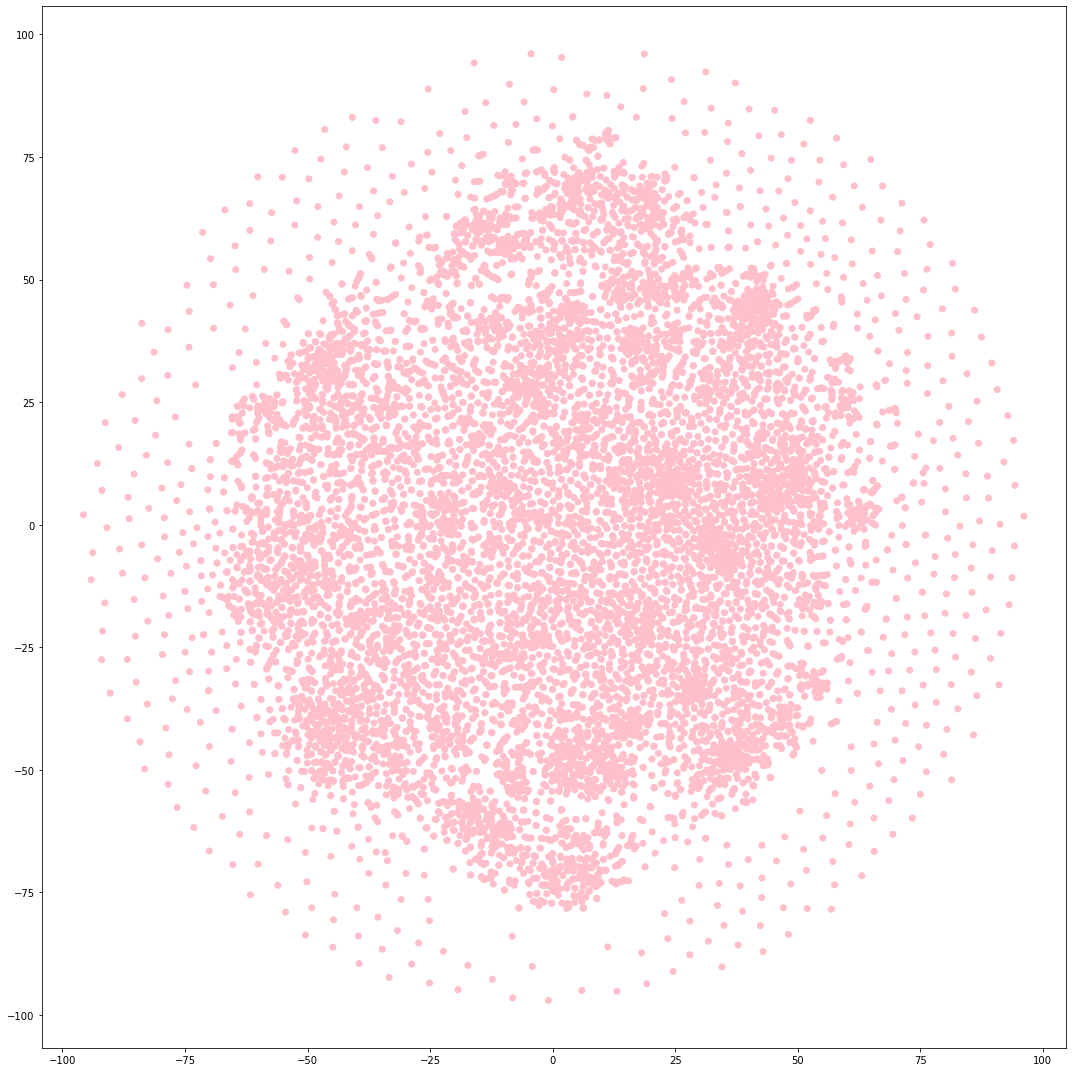

In [37]:
# With results obtained from distance matrix
plt.figure(figsize=(15, 15))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()

###### Sub-groups??

In [41]:
tsne_results_smaller = []
smaller_with_words = []

for i, result in enumerate(tsne_results):
    if result[0] > -25 and result[0] < 0 and result[1] < -85 and result[1] > -100:
        tsne_results_smaller.append(result)
        smaller_with_words.append([result, dist_df.index[i]])

### Does not work, let's try again

In [45]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

tsne_sim = TSNE(random_state=17)
tsne_sim_results = tsne_sim.fit_transform(df.values)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])

2:41:21.938885
3:51:53.718153


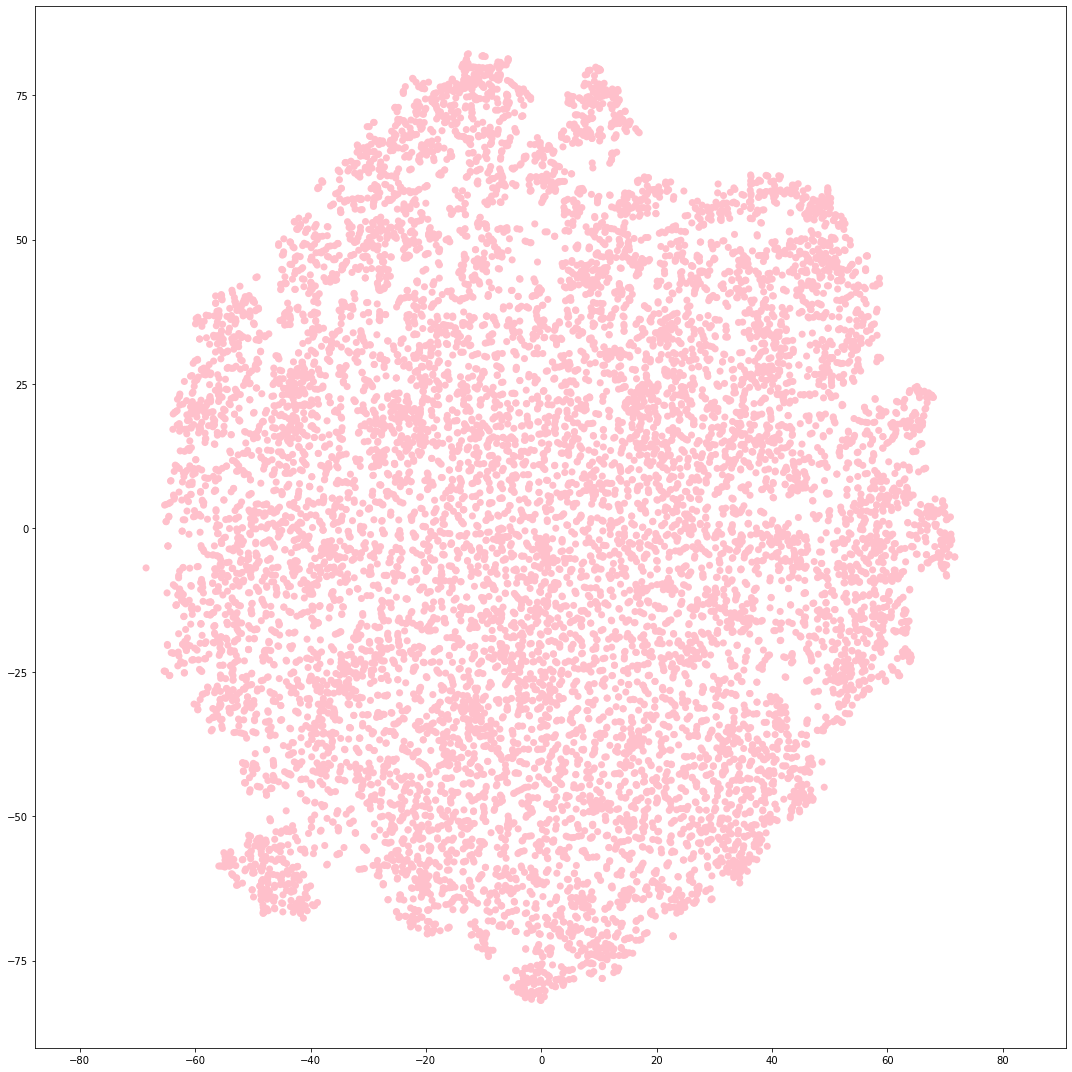

In [46]:
# With results obtained from similarity matrix - metric=precomputed
plt.figure(figsize=(15, 15))
plt.scatter(tsne_sim_results[:, 0], tsne_sim_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()